## Model Prediction Task I 

#### Build a predictive algorithm to determine the factors affecting prices of residential properties in Singapore. You need to provide insights to your reporting officer to detail one or more strategies in curbing housing prices inflation. Your fellow colleagues should be able to access and contribute to your code to replicate the same insights. Their local devices do not have GPU access. Provide justification for any of the choices you have made.

### Setup

In [117]:
import os
import re
from typing import Optional

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import xgboost as xgb


### Data Ingestion & Cleaning

In [ ]:
import pandas as pd
import zipfile
import os

zip_path = '../data/HDB/resale-flat-prices.zip'  # path to zip file

df_list = []

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file_name in zip_ref.namelist():
        if file_name.endswith('.csv'):
            with zip_ref.open(file_name) as f:
                df = pd.read_csv(f)
                df_list.append(df)

df = pd.concat(df_list, ignore_index=True)


We start by cleaning the raw HDB resale data.
Steps include:

- Converting month into proper datetime and extracting year and month_num.
- Deriving additional features like flat_age_years, remaining_lease, storey_mid.
- Grouping rare flat_model values into "OTHERS" to reduce sparsity.
- Adding seasonal encoding (month_sin, month_cos) to represent cyclical months. (January (1) and December (12) are next to each other, but numerically far apart.)
- This ensures our dataset is consistent, free of duplicates, and enriched with features useful for graph analysis.
- Handle duplicates and outliers to avoid biasing the model.  

~ Models are only as good as the quality of the input data ~

In [119]:

def get_storey_mid(storey_range: str) -> Optional[int]:
    """
    Extracts all two-digit numbers from the given string `storey_range` and computes
    the average of these numbers.

    Parameters:
    ----------
    storey_range : str
        A string that may contain numbers, from which the average will be computed.

    Returns:
    --------
    Optional[int]
        The integer value of the average of the numbers found in `storey_range`.
        If no valid numbers are found, returns None.
    """
    
    # Find all numbers in the string
    result = re.findall(r'\d+', storey_range)
    
    # If we found any two-digit numbers, calculate the average
    if result:
        try:
            # Calculate the average of all found numbers
            avg = sum(int(n) for n in result) // len(result)
            return avg
        except ValueError:
            # In case conversion of any number fails
            return None
    
    # Return None if no numbers are found
    return None

def extract_years(text: str) -> Optional[float]:
    """
    Extracts the number of years as a float from a string containing years and months.
    
    The function looks for two-digit numbers in the string, assuming the first is years 
    and the second (if present) is months. It returns years plus months converted to years.
    
    Args:
        text (str): Input string containing years and months (e.g., '60 years 07 months').
        
    Returns:
        Optional[float]: Total years as a float if found, otherwise None.
    """
    
    if not(isinstance(text,str)):
        return None
    result = re.findall(r'\d+', text)
    if result:
        if len(result) > 1:
            year = float(result[0]) + float(result[1]) / 12
        else:
            year = float(result[0])
        return year
    return None

In [120]:
# Each town is mapped into one of Singapore’s planning regions (Central, North, East, West, North-East).  
town_to_region = {'ANG MO KIO': 'NORTH-EAST',
 'BEDOK': 'EAST',
 'BISHAN': 'CENTRAL',
 'BUKIT BATOK': 'WEST',
 'BUKIT MERAH': 'CENTRAL',
 'BUKIT PANJANG': 'WEST',
 'BUKIT TIMAH': 'CENTRAL',
 'CENTRAL AREA': 'CENTRAL',
 'CHOA CHU KANG': 'WEST',
 'CLEMENTI': 'WEST',
 'GEYLANG': 'CENTRAL',
 'HOUGANG': 'NORTH-EAST',
 'JURONG EAST': 'WEST',
 'JURONG WEST': 'WEST',
 'KALLANG/WHAMPOA': 'CENTRAL',
 'MARINE PARADE': 'CENTRAL',
 'PASIR RIS': 'EAST',
 'PUNGGOL': 'NORTH-EAST',
 'QUEENSTOWN': 'CENTRAL',
 'SEMBAWANG': 'NORTH',
 'SENGKANG': 'NORTH-EAST',
 'SERANGOON': 'NORTH-EAST',
 'TAMPINES': 'EAST',
 'TOA PAYOH': 'CENTRAL',
 'WOODLANDS': 'NORTH',
 'YISHUN': 'NORTH',
 'LIM CHU KANG': 'NORTH'}

In [121]:
# Convert 'month' column to datetime, then extract year and numeric month
df["month"] = pd.to_datetime(df["month"], errors="coerce")
df["year"] = df["month"].dt.year
df["month_num"] = df["month"].dt.month  # to avoid overwriting!

# Calculate flat age in years
df['flat_age_years'] = df['year'] - df['lease_commence_date']

# Convert remaining lease string to float years using extract_years
df['remaining_lease'] = df['remaining_lease'].apply(extract_years)

# Derive remaining lease where NA: 99 - flat_age_years
df.loc[df['remaining_lease'].isna(), 'remaining_lease'] = (
    99 - df.loc[df['remaining_lease'].isna(), 'flat_age_years']
)

# Calculate midpoint of storey range
df['storey_mid'] = df['storey_range'].apply(get_storey_mid)

# Standardize flat_type values
df["flat_type"] = df["flat_type"].replace({"MULTI GENERATION": "MULTI-GENERATION"})

# Map town to region
df['region'] = df['town'].map(town_to_region)

# Filter out rows where flat_age_years is negative
df = df[df["flat_age_years"] >= 0]

# Keep first, drop the other duplicates
df.drop_duplicates(keep='first',inplace=True)

if 'month_num' in df.columns:
    df['month_sin'] = np.sin(2*np.pi*df['month_num']/12.0)
    df['month_cos'] = np.cos(2*np.pi*df['month_num']/12.0)

# Group rare flat_model values (<1% frequency) under 'OTHERS'
flat_model_counts = df["flat_model"].value_counts(normalize=True)
rare_models = flat_model_counts[flat_model_counts < 0.01].index
df["flat_model"] = df["flat_model"].replace(rare_models, "OTHERS").str.upper()

# Raw cleaning + Deterministic parsing
# No scaling or normalization yet!
# We can train test split here.

train = df[(df['year'] <= 2016) ]
test  = df[df['year'] >= 2017]

In [122]:
print(f"Train ratio: {len(train)/len(df):.2f}, Test ratio: {len(test)/len(df):.2f}")

Train ratio: 0.90, Test ratio: 0.10


> Train/Test Split Decision:
> I chose 2016 as the chronological cutoff. This ensures:
> - A large training set (1990–2016, ~744k transactions).  
> - A test set (2017–2020, ~80k transactions) that reflects the most recent market regime.  
> - Coverage of both the rapid price escalation pre-2013 and the stabilisation after major cooling measures.  
> - This split simulates a realistic task: learning from history and predicting resale prices.

### Data Visualisations

Before modeling, we explore key trends to understand what drives resale prices.  
The following visualizations highlight temporal trends, flat characteristics, and geographic effects.

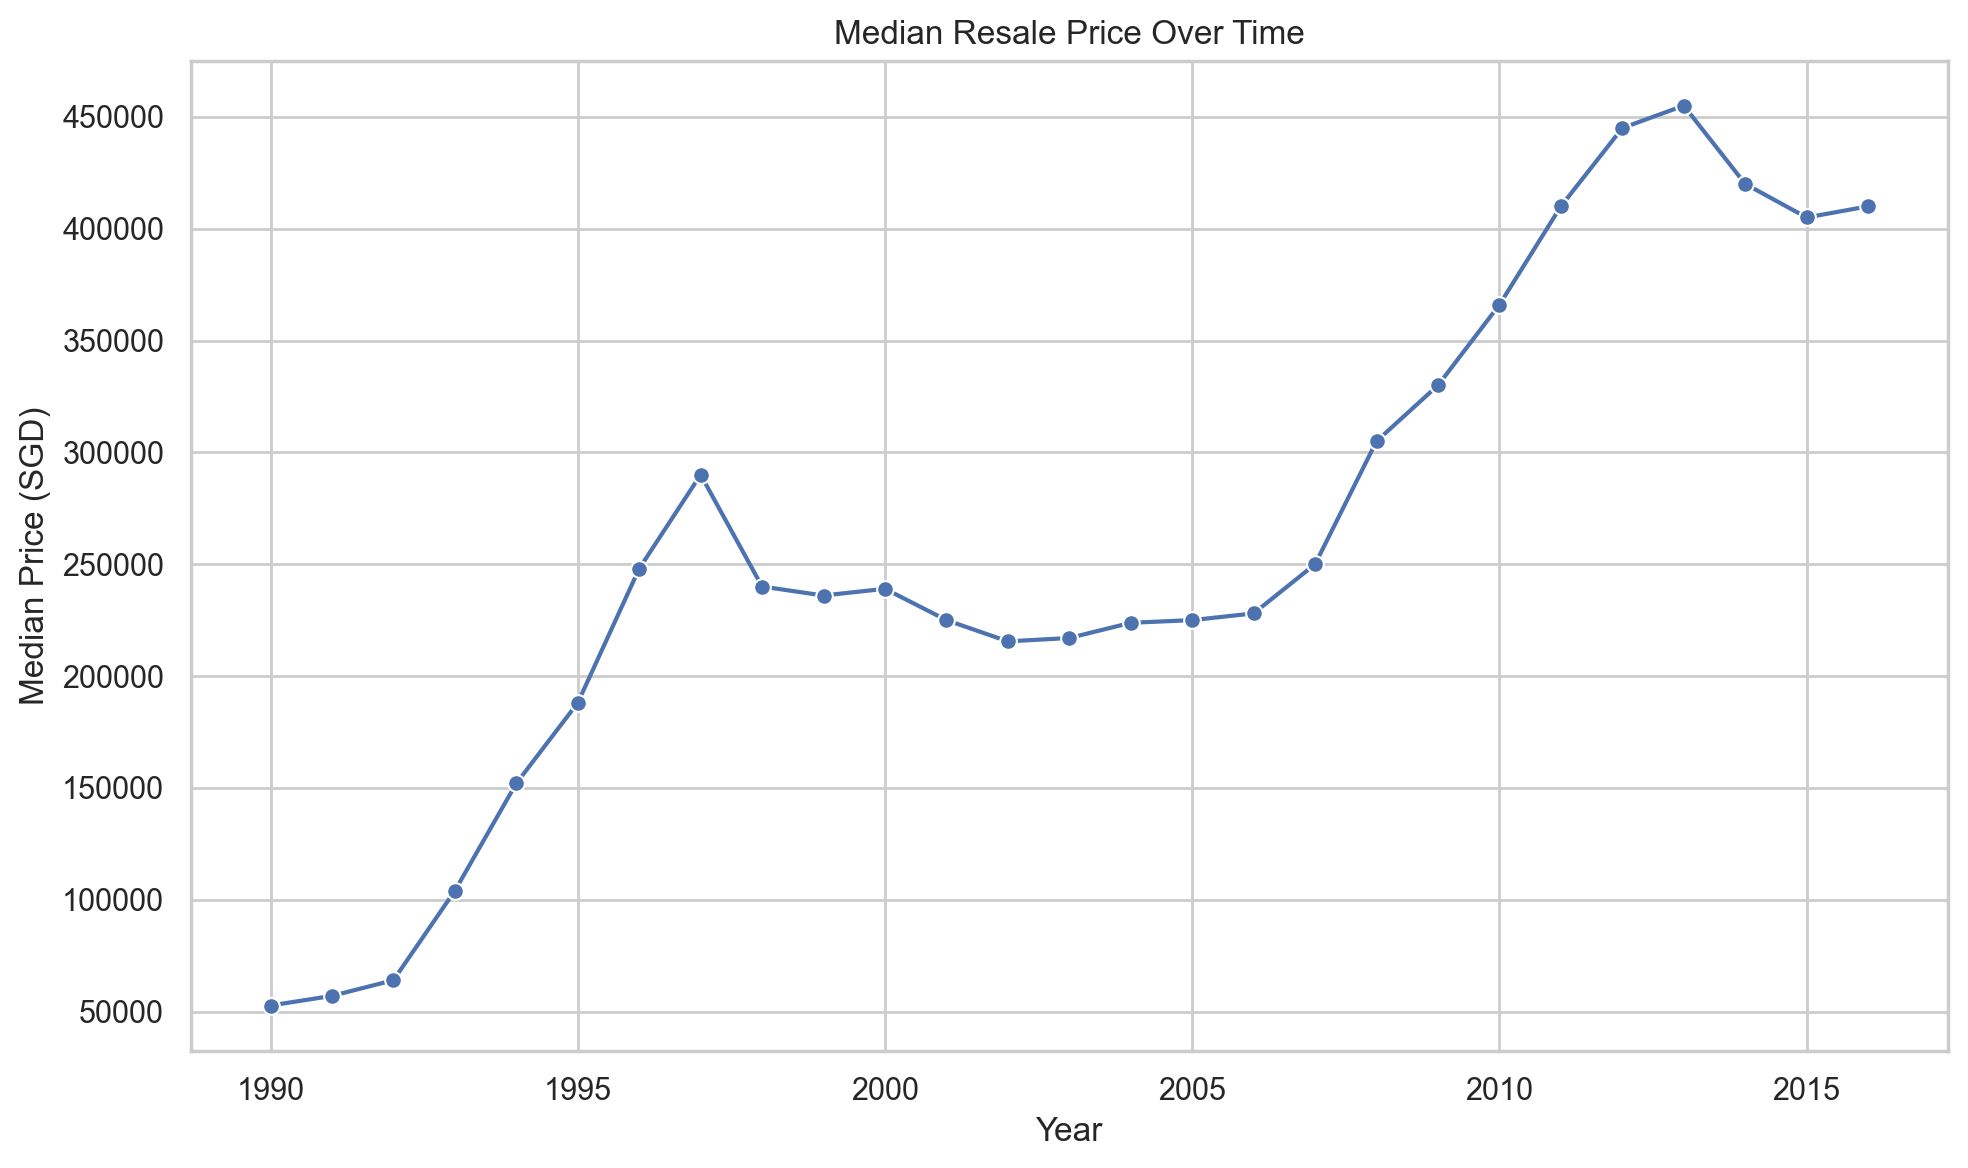

In [123]:
sns.set_theme(style="whitegrid")

#  Median price trend over time ---
yearly = train.groupby("year")["resale_price"].median().reset_index()

plt.figure(figsize=(10,6),dpi=200)
sns.lineplot(data=yearly, x="year", y="resale_price", marker="o")
plt.title("Median Resale Price Over Time")
plt.ylabel("Median Price (SGD)")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

> Interpretation: Resale prices rose sharply in the mid-1990s, dipped after the 1997 Asian Financial Crisis, then accelerated again until 2013 when government cooling measures (e.g., Total Debt Servicing Ratio, Additional Buyer’s Stamp Duty) were introduced. Prices have been more stable since then.

> Price inflation directly impacts affordability and household debt. The data shows policy interventions do have measurable effects. 

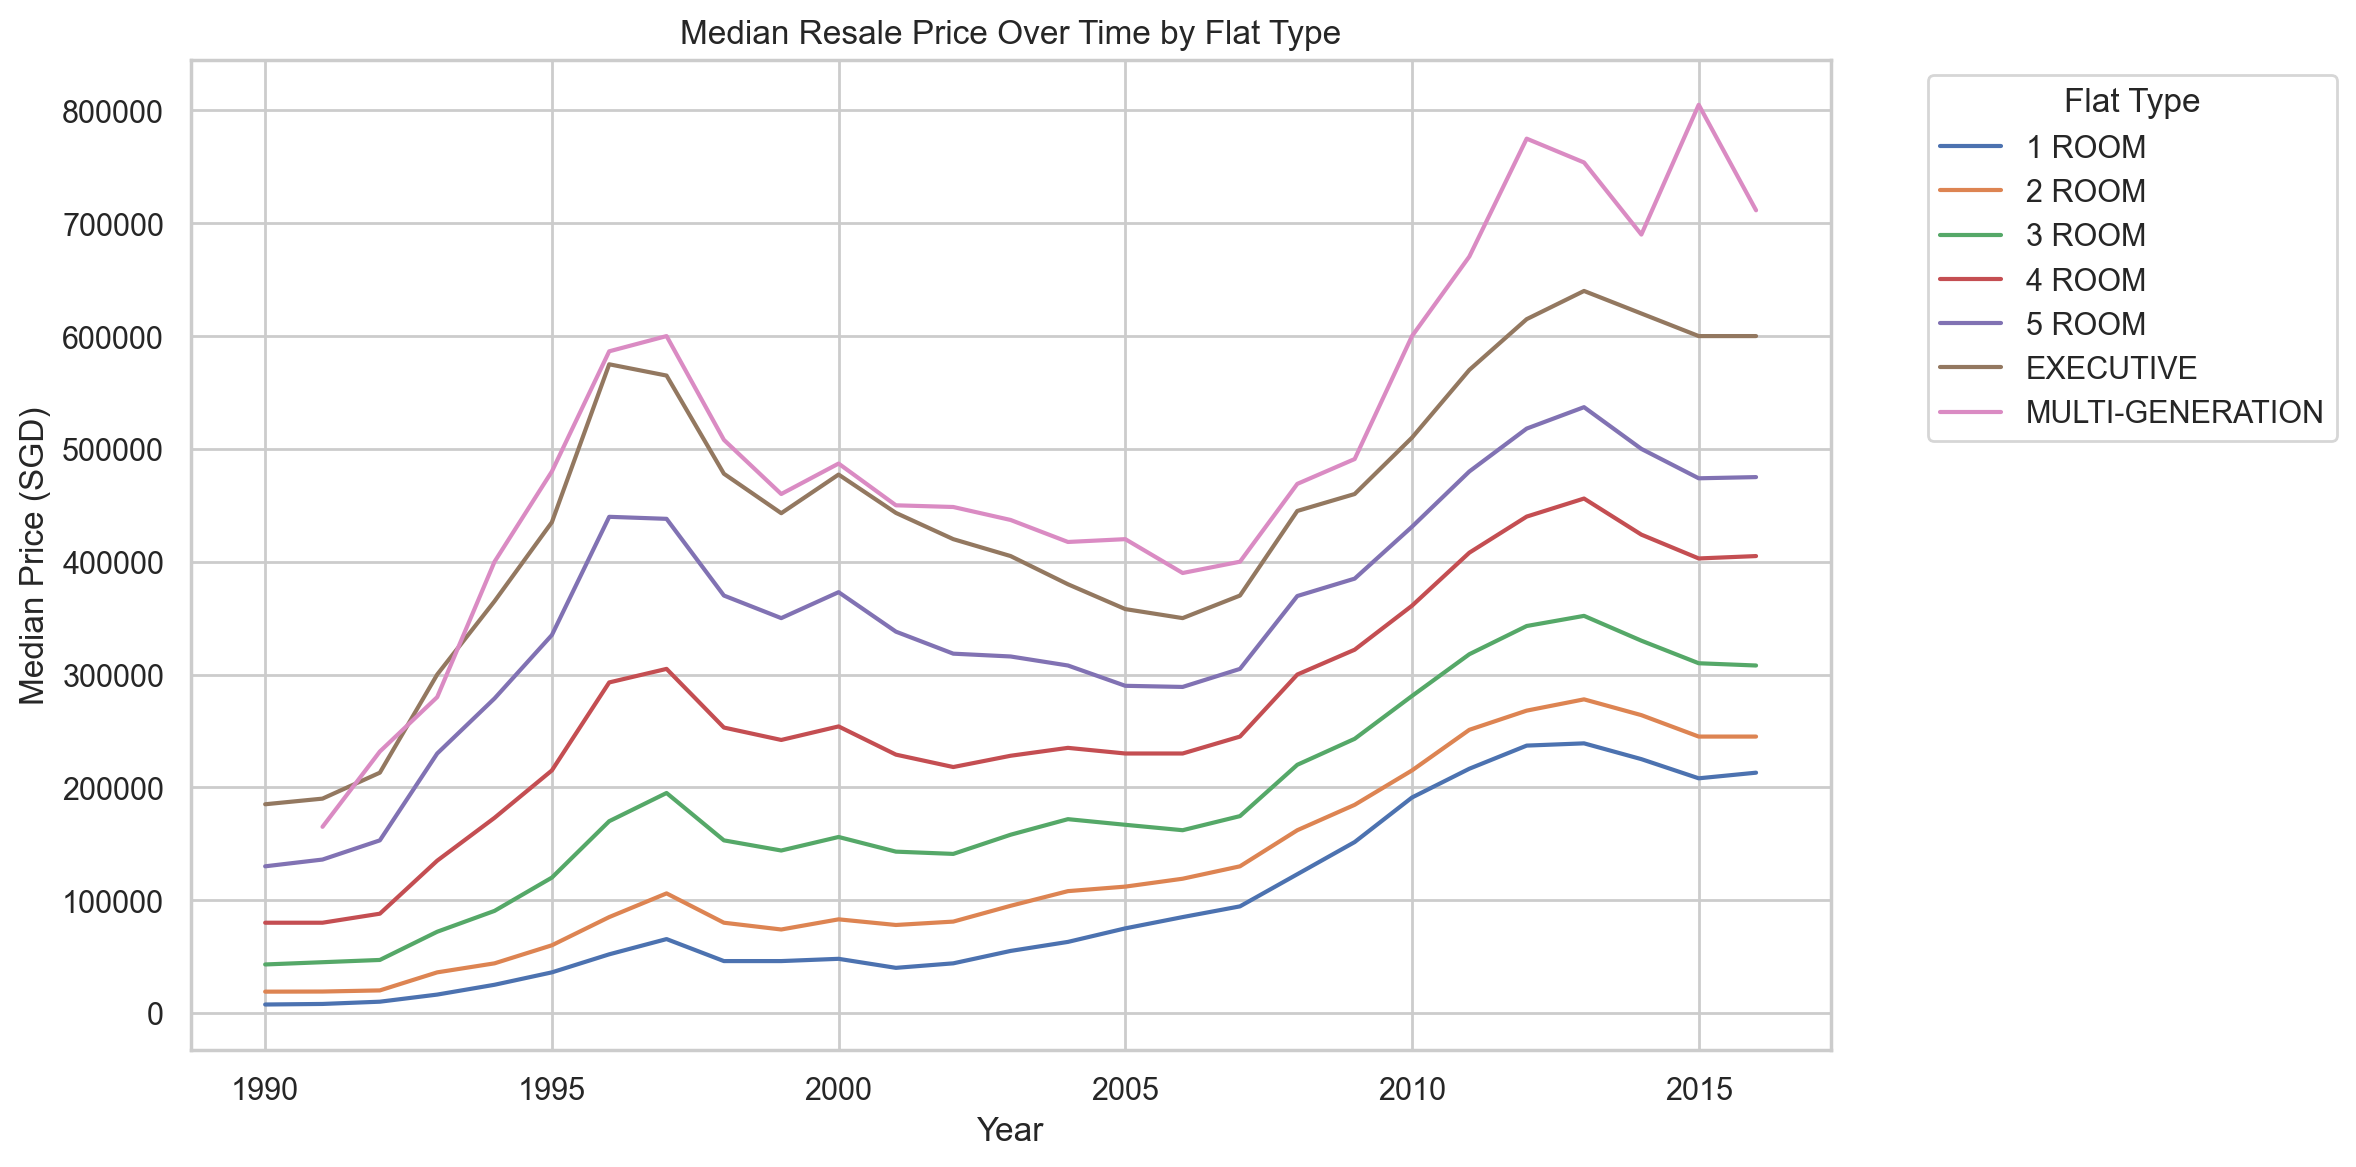

In [124]:
#  Median price trend by flat type
flat_yearly = (
    train.groupby(["year","flat_type"])["resale_price"]
      .median()
      .reset_index()
)

plt.figure(figsize=(12,6),dpi=200)
sns.lineplot(data=flat_yearly, x="year", y="resale_price", hue="flat_type")
plt.title("Median Resale Price Over Time by Flat Type")
plt.ylabel("Median Price (SGD)")
plt.xlabel("Year")
plt.legend(title="Flat Type", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

> **Interpretation:** Larger flats experienced steeper appreciation compared to smaller units, particularly in the 2007–2013 run-up.  
> **Conclusion:** Families needing bigger flats face disproportionate cost burdens, while smaller flats remain relatively affordable (ish).

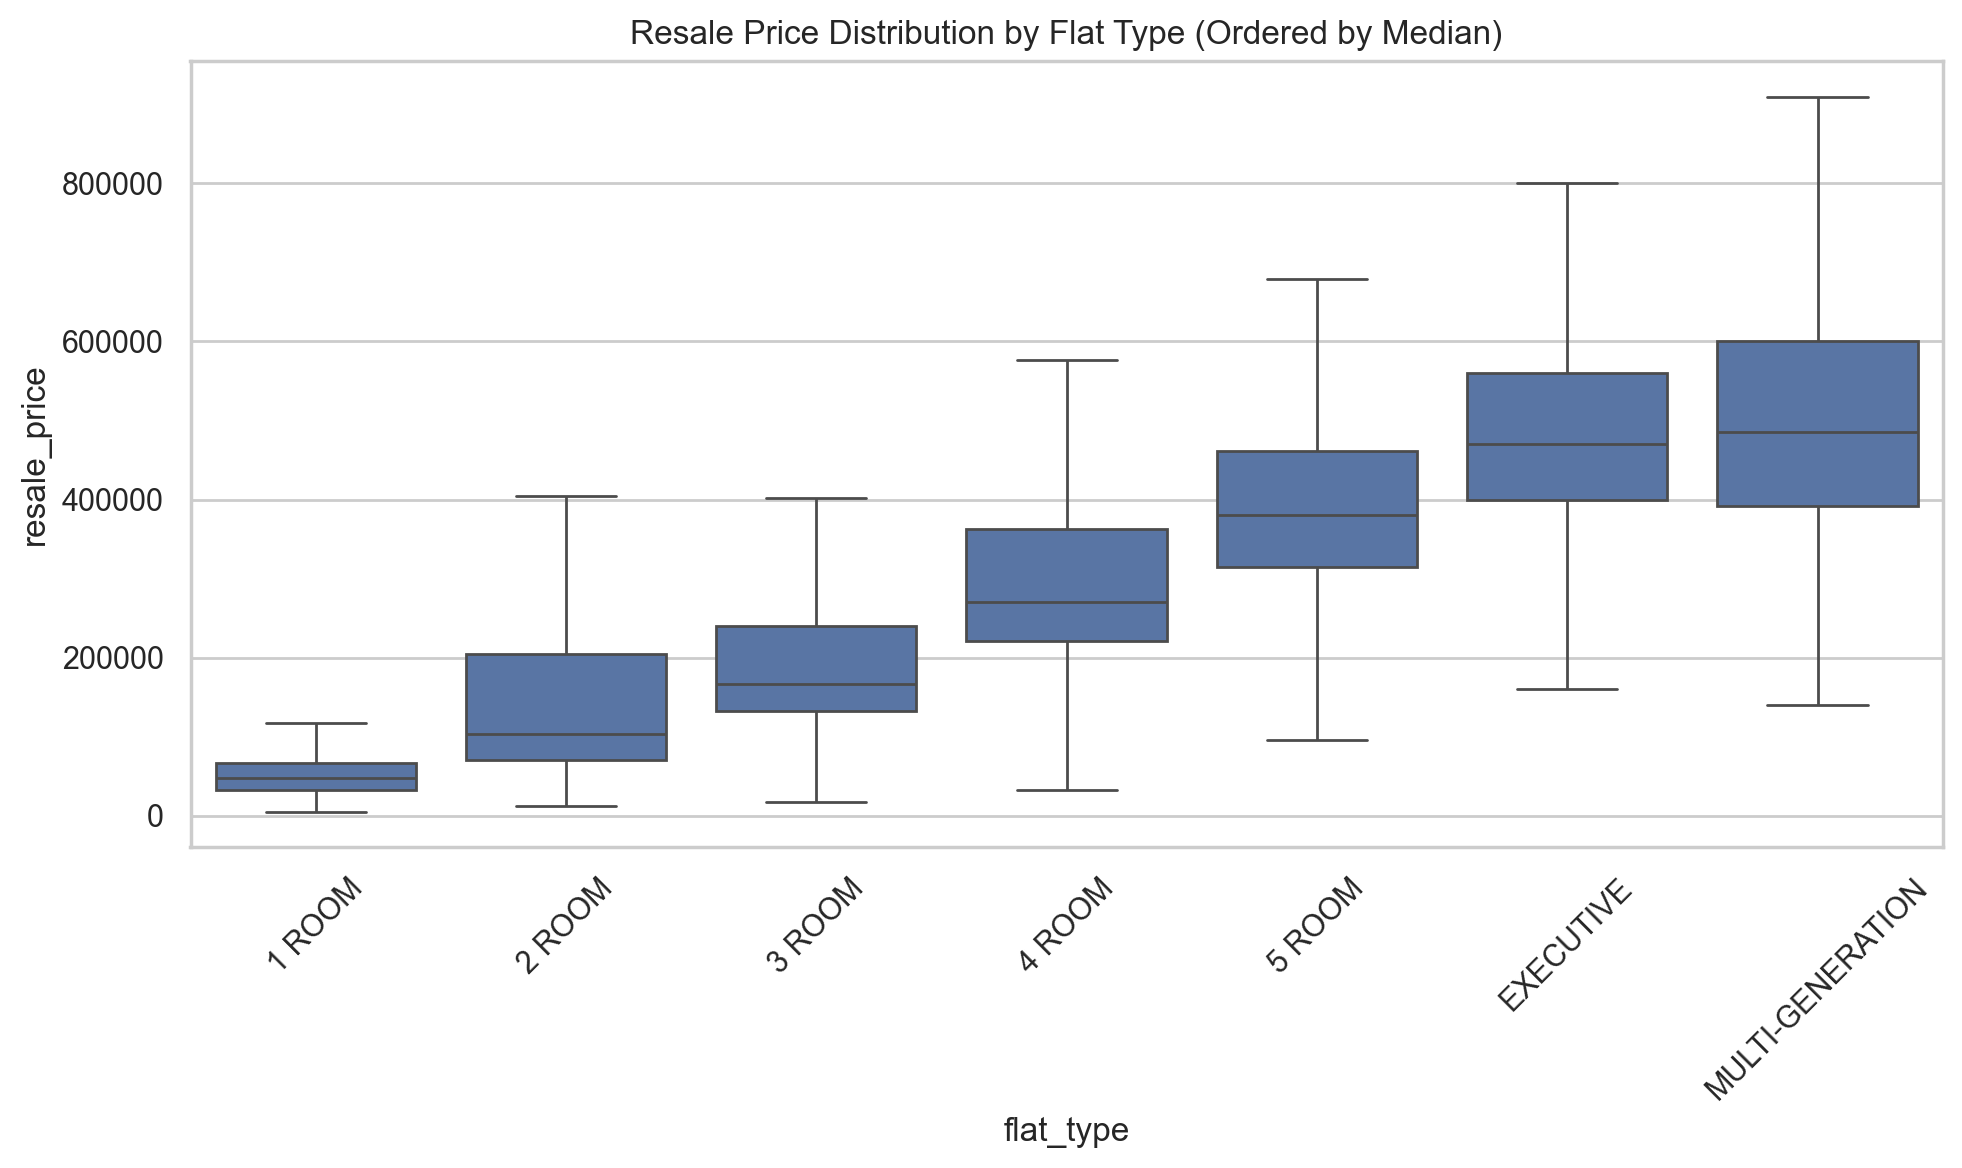

In [125]:
# Boxplot by flat type (ordered by median)  
median_order = (
    train.groupby("flat_type")["resale_price"]
      .median()
      .sort_values()
      .index
)

plt.figure(figsize=(10,6),dpi=200)
sns.boxplot(
    data=df, 
    x="flat_type", y="resale_price",
    order=median_order,
    showfliers=False
)
plt.title("Resale Price Distribution by Flat Type (Ordered by Median)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> **Interpretation:** Size matters. 1 and 2 room flats remain at the low end, while Executive and Multi-generation flats command the highest medians and widest spreads.  
> **Conclusion:** Affordability gaps between flat types can exacerbate inequality between smaller households and multi-generational families.


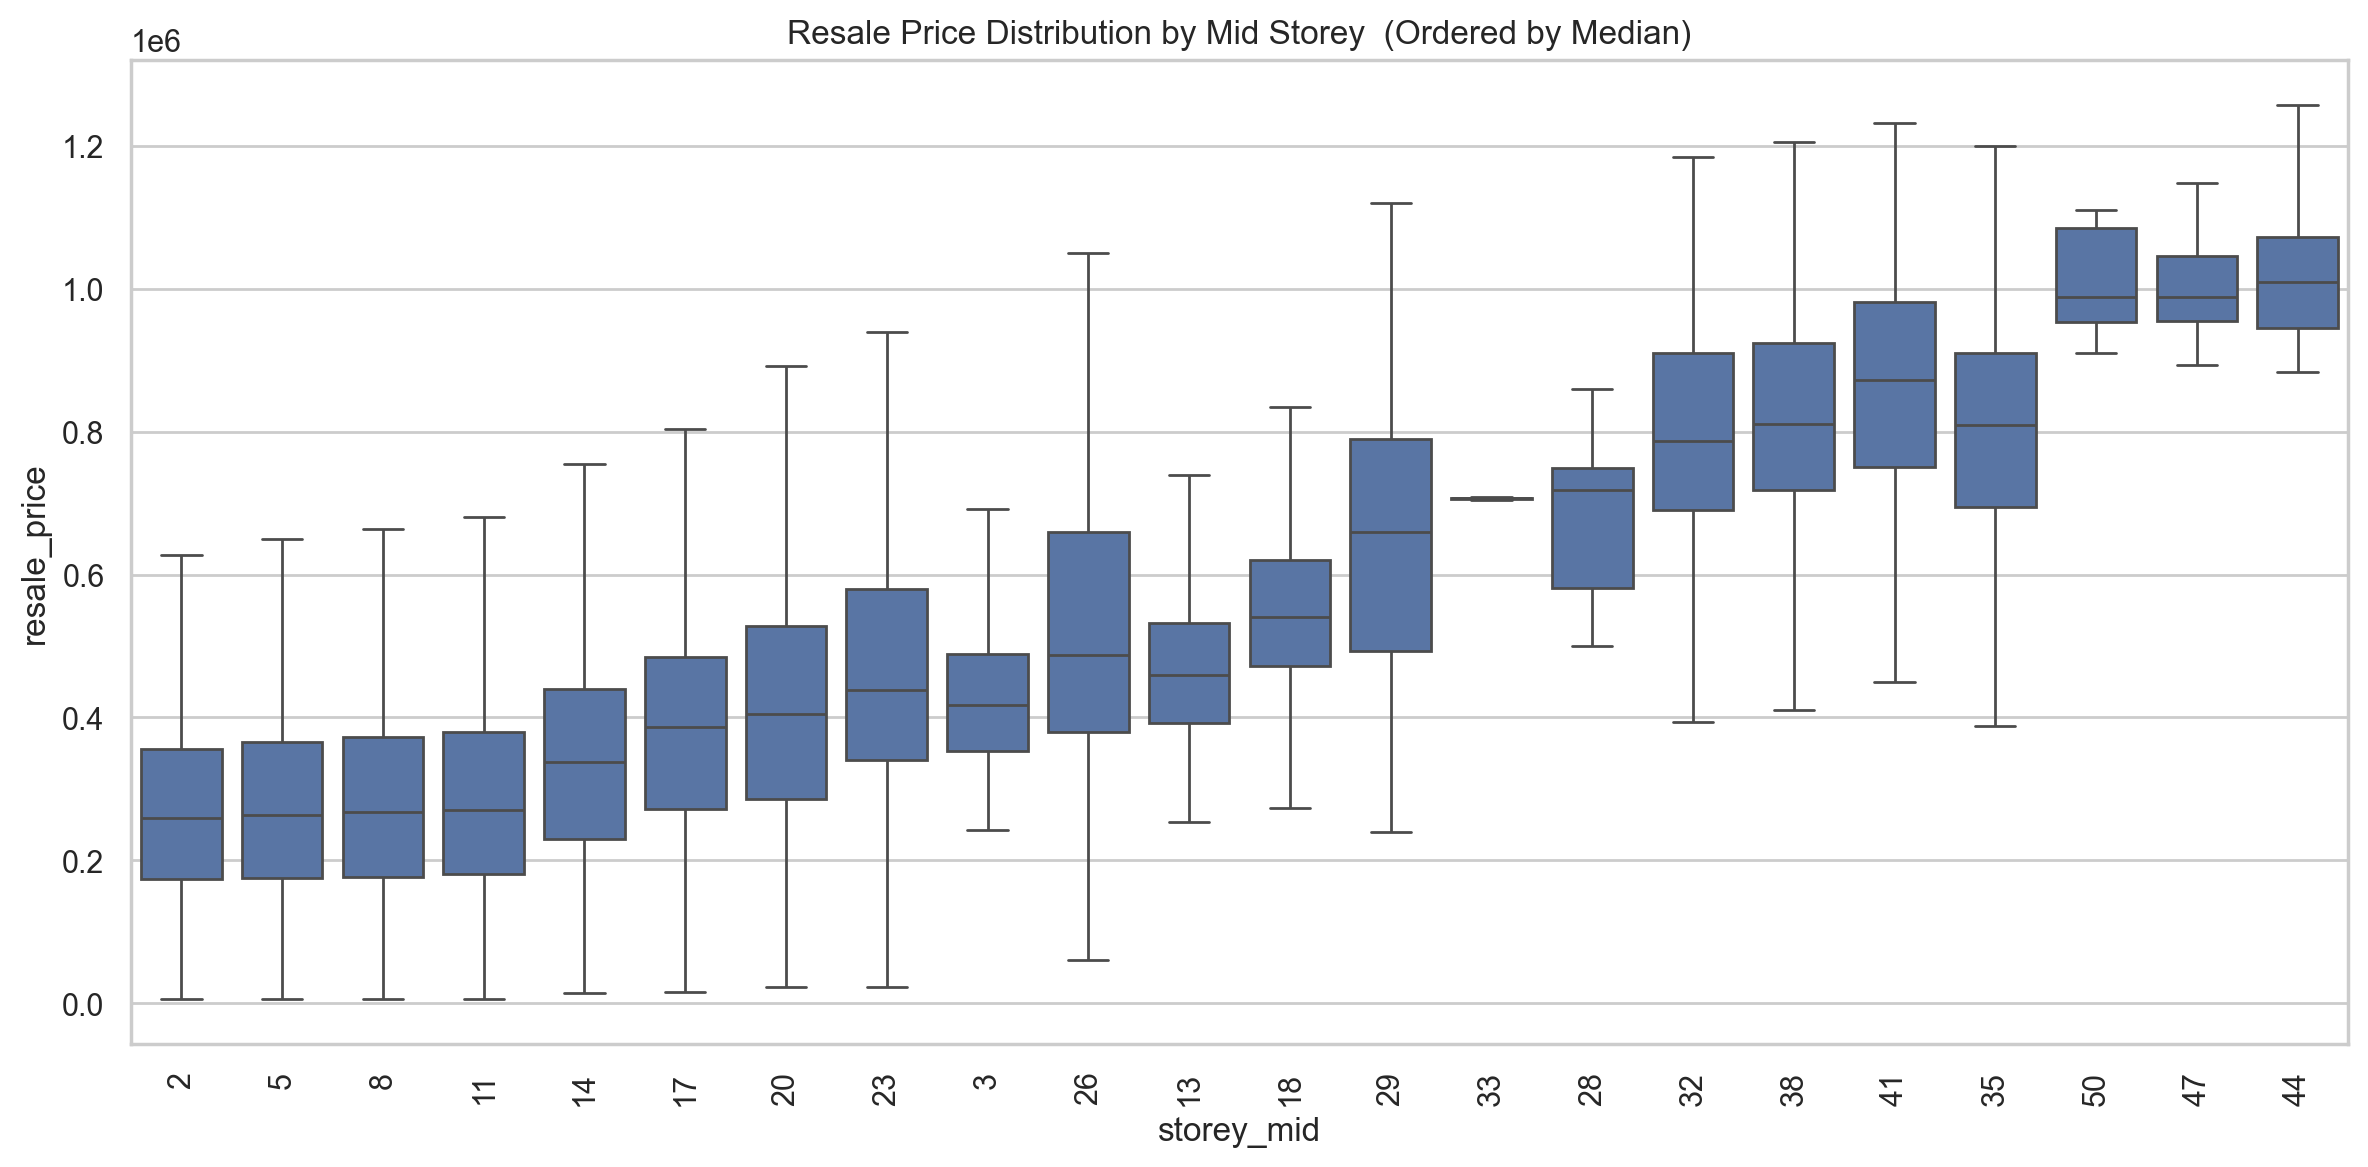

In [126]:
# Boxplot by storey range (ordered by median) ---
if "storey_mid" in df.columns:
    median_order_storey = (
        train.groupby("storey_mid")["resale_price"]
          .median()
          .sort_values()
          .index
    )
    plt.figure(figsize=(12,6),dpi=200)
    sns.boxplot(
        data=df,
        x="storey_mid", y="resale_price",
        order=median_order_storey,
        showfliers=False
    )
    plt.title("Resale Price Distribution by Mid Storey  (Ordered by Median)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

> **Interpretation:** Higher floors are more expensive, with 50 flats  transacting above 1M.  
> **Conclusion:** Height premium reflects both scarcity and lifestyle preferences (better views, less noise?). This adds to inflation in newer, high-rise projects.

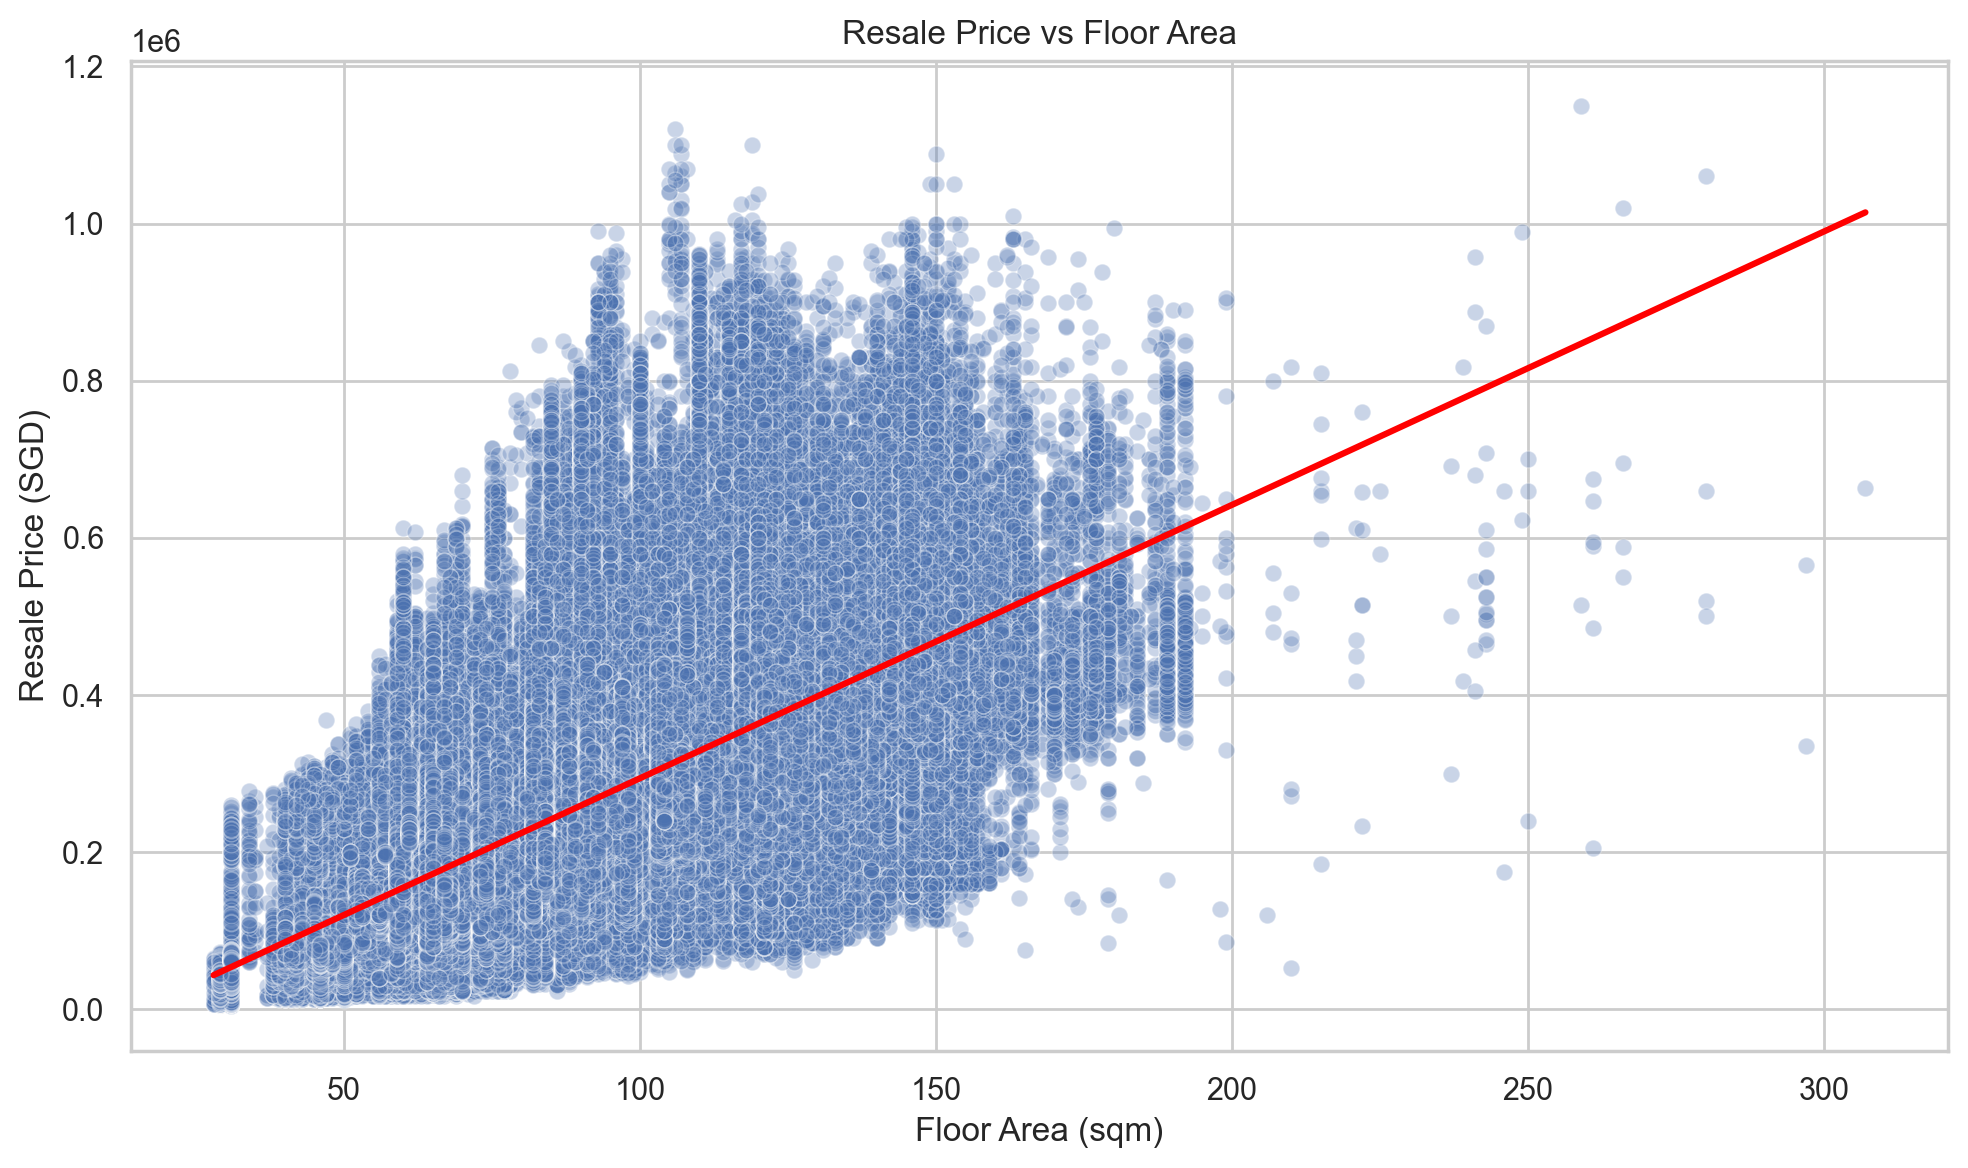

In [127]:
# Floor area vs price
if "floor_area_sqm" in df.columns:
    plt.figure(figsize=(10,6),dpi=200)
    sns.scatterplot(data=train, 
                    x="floor_area_sqm", y="resale_price", alpha=0.3)
    sns.regplot(data=train, x="floor_area_sqm", y="resale_price",
                scatter=False, color="red")
    plt.title("Resale Price vs Floor Area")
    plt.xlabel("Floor Area (sqm)")
    plt.ylabel("Resale Price (SGD)")
    plt.tight_layout()
    plt.show()

> **Interpretation:** Resale prices scale with floor area, but diminishing returns appear after ~150 sqm — very large flats do not command proportionately higher resale prices.  
> **Conclusion:** Oversized units may not be an efficient use of scarce land, especially when smaller units are in higher demand.  


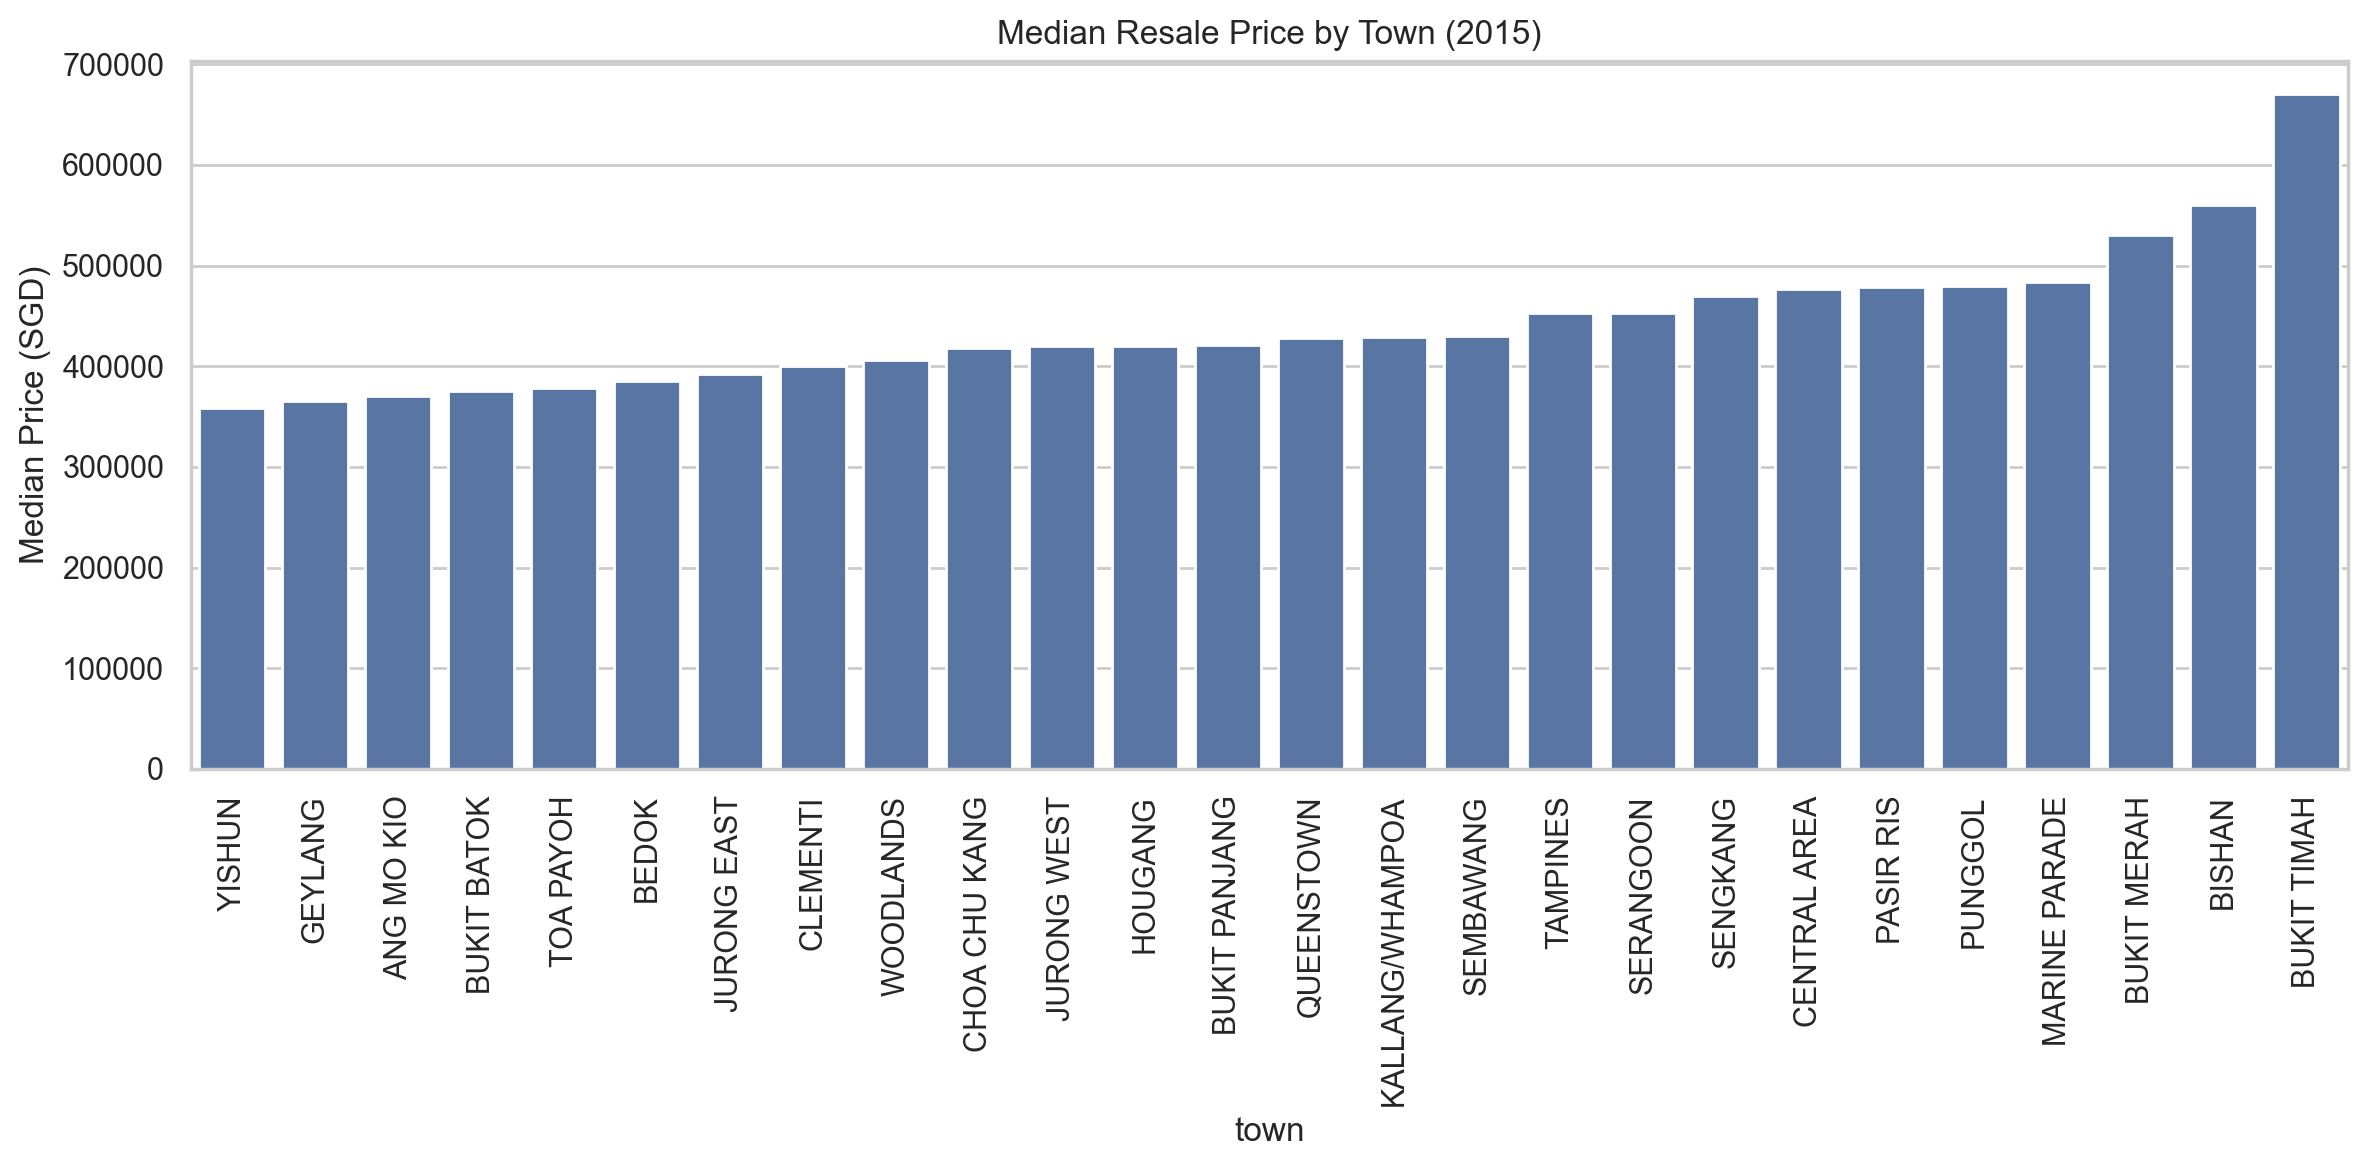

In [128]:
# Median price by town
town_median = (
    train[train['year']>2010].groupby("town")["resale_price"]
      .median()
      .sort_values()
      .reset_index()
)

plt.figure(figsize=(12,6),dpi=200)
sns.barplot(data=town_median, x="town", y="resale_price", order=town_median["town"])
plt.title("Median Resale Price by Town (2015)")
plt.xticks(rotation=90)
plt.ylabel("Median Price (SGD)")
plt.tight_layout()
plt.show()

> **Interpretation:** From 2010- 2015, Mature central towns (Bishan, Bukit Timah, Bukit Merah) have the highest resale medians, often exceeding \$400k+, while peripheral estates (Yishun, Toa Payoh, Ang Mo Kio) are significantly cheaper.  
> **Conclusion:** Location premiums reinforce central-peripheral inequality, with households priced out of central areas.  

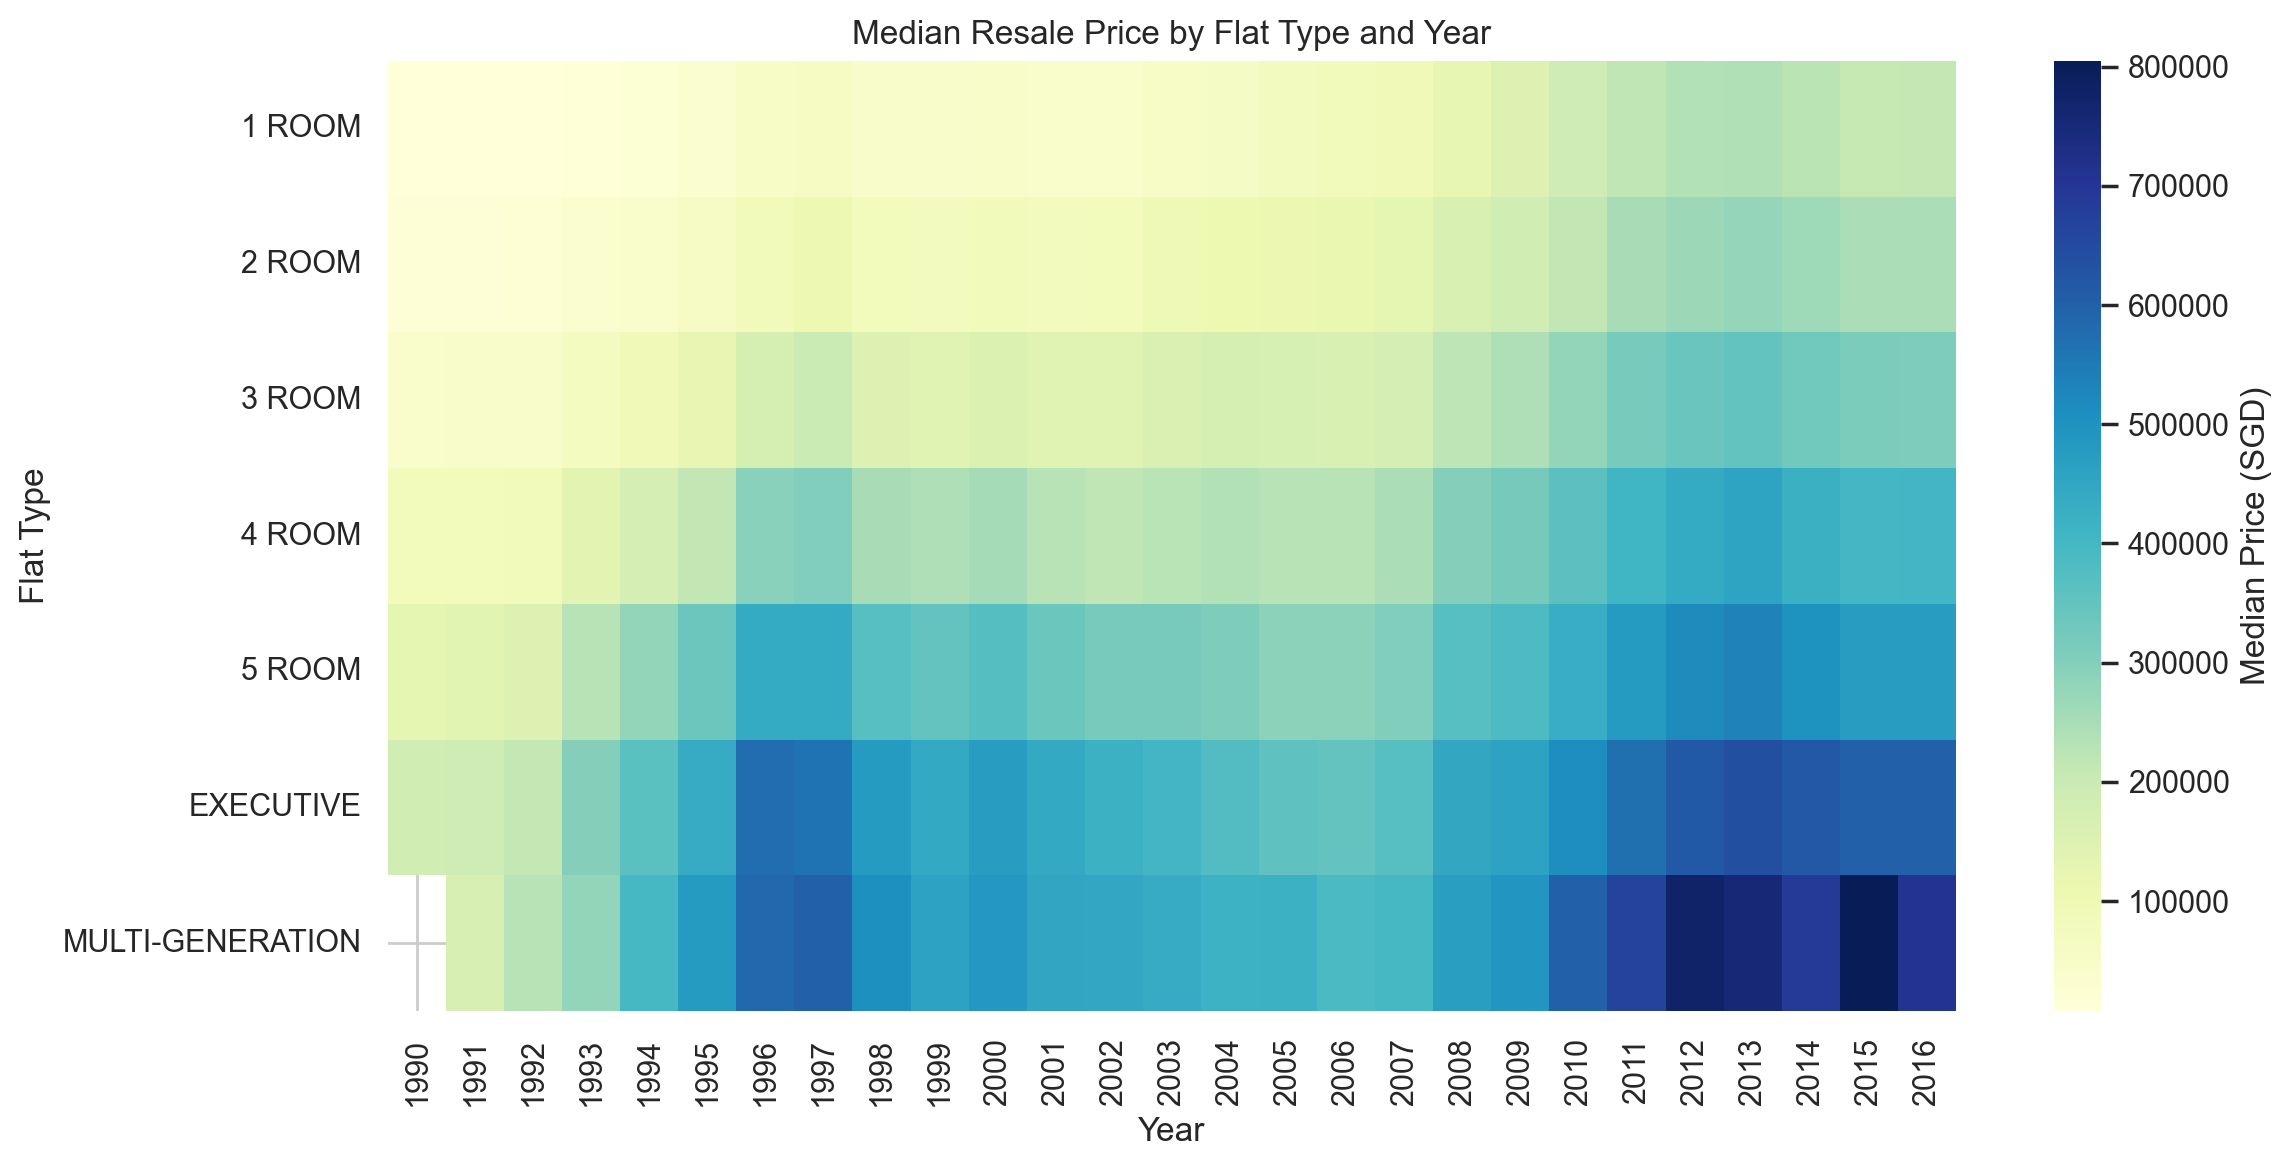

In [129]:
# Heatmap: Year × Flat Type
pivot = train.pivot_table(values="resale_price", index="flat_type", columns="year", aggfunc="median")
plt.figure(figsize=(12,6),dpi=200)
sns.heatmap(pivot, cmap="YlGnBu", annot=False, cbar_kws={"label": "Median Price (SGD)"})
plt.title("Median Resale Price by Flat Type and Year")
plt.ylabel("Flat Type")
plt.xlabel("Year")
plt.tight_layout()
plt.show()


> **Interpretation:** Inflation is broad-based across all flat types, but Executive and Multi-generation flats saw the steepest increases post-2009, while 1- and 2-room flats remained relatively stable.  
> **Conclusion:** Policy interventions affect flat types unevenly, potentially widening social divides.

### Feature Engineering

 

In [130]:
# Identify categorical and numerical columns
categorical = train.select_dtypes(include='O').columns.tolist()
numerical   = train.select_dtypes(exclude='O').columns.tolist()

print("Categorical column unique value counts:")
for col in categorical:
    print(f"{col:20} → {train[col].nunique()} unique values")

print("\nNumerical column unique value counts:")
for col in numerical:
    print(f"{col:20} → {train[col].nunique()} unique values")

Categorical column unique value counts:
town                 → 27 unique values
flat_type            → 7 unique values
block                → 2139 unique values
street_name          → 542 unique values
storey_range         → 25 unique values
flat_model           → 10 unique values
region               → 5 unique values

Numerical column unique value counts:
month                → 324 unique values
floor_area_sqm       → 209 unique values
lease_commence_date  → 48 unique values
remaining_lease      → 51 unique values
resale_price         → 7899 unique values
year                 → 27 unique values
month_num            → 12 unique values
flat_age_years       → 51 unique values
storey_mid           → 22 unique values
month_sin            → 11 unique values
month_cos            → 11 unique values


In [131]:
# Drop block (2454 unique) and street_name (568 unique)
# Drop storey_range (25 unique):
#   - Redundant as I engineered 'storey_mid' to a numerical data column
# Keep:
#   - town (27 unique) : interpretable spatial unit, policy-relevant.
#   - flat_type (7 unique) : strong affordability/size signal.
#   - flat_model (10 unique) : design/era of flat, policy-relevant.
#   - region (5 unique) → coarse spatial grouping, good for interpretation.

keep_categorical_columns = ['town','flat_type','flat_model','region']

In [132]:
# Drop 'month':
#   - Redundant with derived 'month_num' and 'year'.
# Target variable is resale price.
# Keep:
#   - month_num  
#   - floor_area_sqm  
#   - lease_commence_date (may be collinear with flat_age_years/remaining lease, will diagnose).
#   - remaining_lease
#   - year
#   - flat_age_years → engineered from lease_commence_date.
#   - storey_mid → engineered from storey_range. Removed storey_range (categorical)
keep_numerical_columns = ['month_num',
                          'floor_area_sqm',
                          'lease_commence_date',
                          'remaining_lease',
                          'year',
                          'flat_age_years',
                          'storey_mid']

print("Kept categorical columns:", keep_categorical_columns)
print("Kept numerical columns:", keep_numerical_columns)

Kept categorical columns: ['town', 'flat_type', 'flat_model', 'region']
Kept numerical columns: ['month_num', 'floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'year', 'flat_age_years', 'storey_mid']


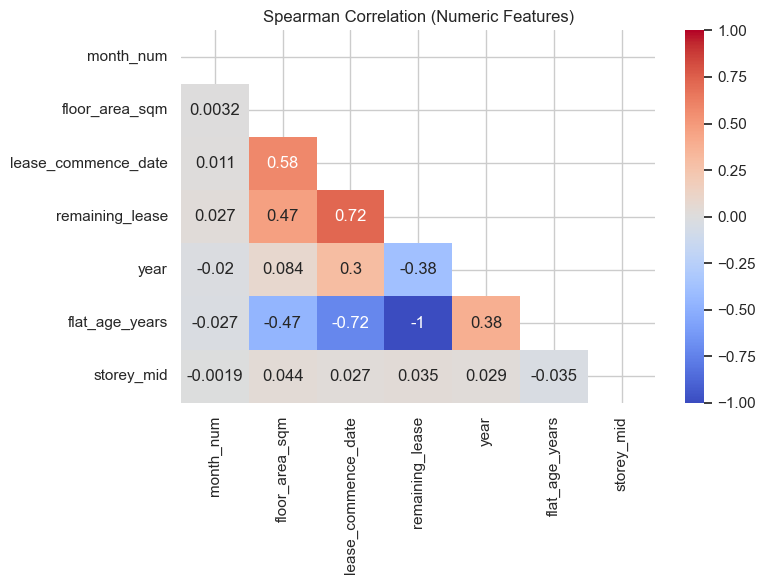

In [133]:
import numpy as np

corr_matrix = train[keep_numerical_columns].dropna().corr(method='spearman')

# Mask the upper triangle (including the diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(corr_matrix,mask=mask, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Spearman Correlation (Numeric Features)')
plt.tight_layout()
plt.show()

Very strong multicollinearity exists between lease-related variables (`remaining_lease`, `flat_age_years`, `lease_commence_date`, `year`)

In [134]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Assuming 'train' and 'keep_numerical_columns' are defined
# Drop rows with any NaN values in the numerical columns
X = train[keep_numerical_columns].dropna()

# Ensure that all columns are numeric (convert to float if necessary)
X = X.apply(pd.to_numeric, errors='coerce')

# Drop any rows where conversion to numeric results in NaN
X = X.dropna()

# Add a constant column for the intercept term
X_with_const = sm.add_constant(X)

# Calculate VIF
vif = pd.DataFrame({
    "feature": ['const'] + keep_numerical_columns,
    "VIF": [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
})

vif

/home/ash/anaconda3/envs/link_env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/home/ash/anaconda3/envs/link_env/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,month_num,1.000663
2,floor_area_sqm,1.396895
3,lease_commence_date,inf
4,remaining_lease,9644.319513
5,year,inf
6,flat_age_years,inf
7,storey_mid,1.006843


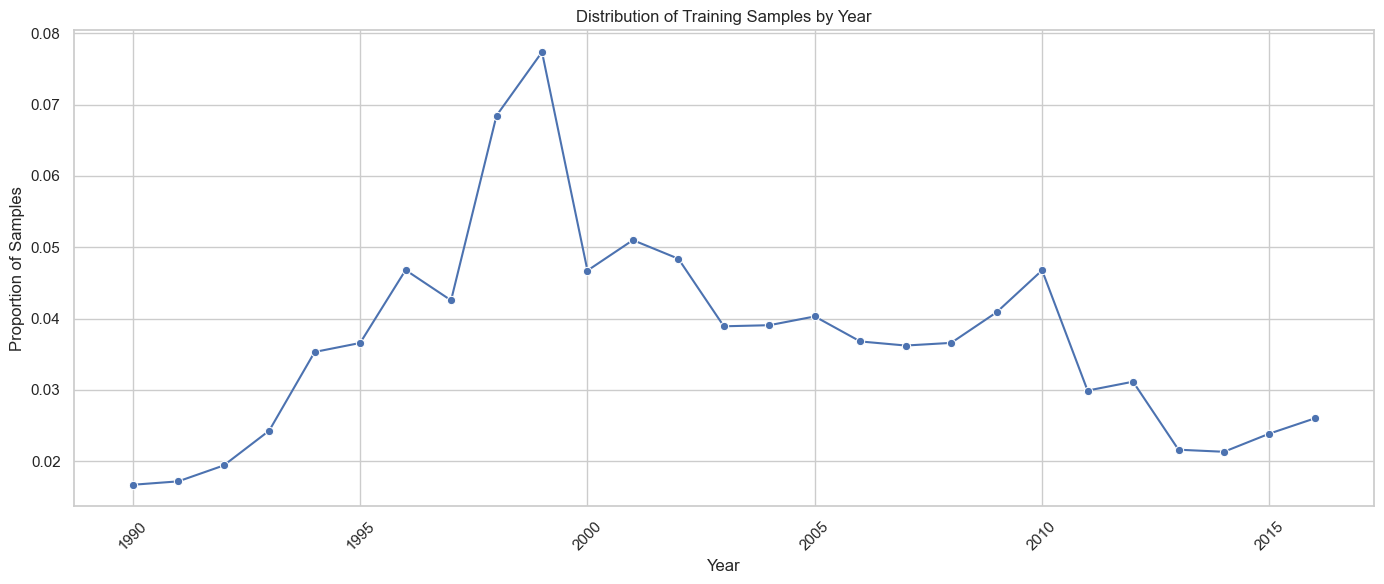

In [135]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate normalized counts
year_distribution = (train['year'].value_counts(normalize=True).sort_index())

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(x=year_distribution.index, y=year_distribution.values, marker='o')

plt.title('Distribution of Training Samples by Year')
plt.xlabel('Year')
plt.ylabel('Proportion of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model will overweight the late-1990s boom years!

In [136]:
reduced_cols = ["floor_area_sqm", "storey_mid", 
                "remaining_lease", "year", 
                "month_sin", "month_cos"]
X_reduced = train[reduced_cols].dropna()
X_reduced = X_reduced.apply(pd.to_numeric, errors='coerce')

X_std = (X_reduced - X_reduced.mean()) / X_reduced.std(ddof=0).convert_dtypes()
vif = pd.DataFrame({
    "feature": X_std.columns,
    "VIF": [variance_inflation_factor(X_std.values, i) for i in range(X_std.shape[1])]
}).sort_values("VIF", ascending=False)
display(vif)

,feature,VIF
2,remaining_lease,1.708144
0,floor_area_sqm,1.397161
3,year,1.380366
1,storey_mid,1.006845
5,month_cos,1.001362
4,month_sin,1.000511


In [137]:
num_features = ["floor_area_sqm", "storey_mid", 
                "remaining_lease", #"year", 
                "month_sin", "month_cos"]

cat_features = ["town", "flat_type", "flat_model", "region"]


model_features = num_features + cat_features   

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


After removing `lease_commence_date` and `flat_age_years`, all remaining numeric predictors show VIF values between 1.0–1.7, which is well below the common threshold of 5. This confirms that multicollinearity has been mitigated.  


#### Baseline Models (CPU-only!)

> **Cross-Validation Choice:**  
> For temporal data like housing transactions, random K-Fold cross-validation would cause data leakage, since the model could be trained on future years while validating on past years.  
> Instead, we used a chronological split (train ≤2016, test ≥2017).  
> As an extension, one could also apply `TimeSeriesSplit` (expanding window) to generate multiple validation folds. This better simulates the real-world task: learning from history to predict the future.


In [138]:
# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0,random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=50, 
        max_depth=10, 
        n_jobs=-1,
        random_state=42),
    "XGBoost": xgb.XGBRegressor(device='cpu', tree_method="hist", n_jobs=-1, random_state=42)
}

tscv = TimeSeriesSplit(n_splits=5)
results = {name: {"R2_log": [], "RMSE": [], "MAE": []} for name in models}

# --- Cross-validation ---
for fold, (train_idx, val_idx) in enumerate(tscv.split(train)):
    X_train, X_val = train.iloc[train_idx], train.iloc[val_idx]
    y_train, y_val = X_train['resale_price'], X_val['resale_price']
    X_train = X_train[model_features]
    X_val   = X_val[model_features]

    # log-transform target
    y_train_log = np.log(y_train)
    y_val_log   = np.log(y_val)

    for name, model in models.items():
        pipe = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("regressor", model)
        ])
        pipe.fit(X_train, y_train_log)   # fit on log prices
        y_pred_log = pipe.predict(X_val)

        # log-scale R²
        r2_log = r2_score(y_val_log, y_pred_log)

        # back-transform
        y_pred_real = np.exp(y_pred_log)
        rmse = root_mean_squared_error(y_val, y_pred_real)
        mae  = mean_absolute_error(y_val, y_pred_real)

        results[name]["R2_log"].append(r2_log)
        results[name]["RMSE"].append(rmse)
        results[name]["MAE"].append(mae)

# Summarise CV
for name, scores in results.items():
    print(f"\n{name}")
    print(f" R² (log) : {np.mean(scores['R2_log']):.3f} ± {np.std(scores['R2_log']):.3f}")
    print(f" RMSE     : {np.mean(scores['RMSE']):,.0f} ± {np.std(scores['RMSE']):,.0f}")
    print(f" MAE      : {np.mean(scores['MAE']):,.0f} ± {np.std(scores['MAE']):,.0f}")


LinearRegression
 R² (log) : 0.508 ± 0.111
 RMSE     : 93,947 ± 30,741
 MAE      : 74,150 ± 33,917

Ridge
 R² (log) : 0.508 ± 0.111
 RMSE     : 93,946 ± 30,742
 MAE      : 74,147 ± 33,918

RandomForest
 R² (log) : 0.401 ± 0.207
 RMSE     : 89,238 ± 29,019
 MAE      : 68,865 ± 28,572

XGBoost
 R² (log) : 0.484 ± 0.180
 RMSE     : 85,069 ± 29,286
 MAE      : 64,923 ± 27,490


In [139]:
# Final model on full training
best_model = LinearRegression() 
final_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", best_model)
])

X_train_full = train[model_features]
y_train_full = np.log(train['resale_price'])
final_pipe.fit(X_train_full, y_train_full)

# --- Holdout test (2017–2020) ---
X_test = test[model_features]
y_test = test['resale_price']
y_test_log = np.log(y_test)

y_pred_log = final_pipe.predict(X_test)
y_pred_real = np.exp(y_pred_log)

In [140]:
print("\nFinal Holdout Test Performance (2017–2020):")
print(f" R²   (log-space): {r2_score(y_test_log, y_pred_log):.3f}")
print(f" RMSE : {root_mean_squared_error(y_test, y_pred_real):,.0f}")
print(f" MAE  : {mean_absolute_error(y_test, y_pred_real):,.0f}")

# --- Per-year breakdown (nice for report) ---
for yr in sorted(test['year'].unique()):
    mask = test['year'] == yr
    r2_yr = r2_score(np.log(y_test[mask]), y_pred_log[mask])
    rmse_yr = root_mean_squared_error(y_test[mask], y_pred_real[mask])
    mae_yr  = mean_absolute_error(y_test[mask], y_pred_real[mask])
    print(f"Year {yr}: R²(log)={r2_yr:.3f}, RMSE={rmse_yr:,.0f}, MAE={mae_yr:,.0f}")



Final Holdout Test Performance (2017–2020):
 R²   (log-space): -0.688
 RMSE : 184,088
 MAE  : 132,323
Year 2017: R²(log)=-0.481, RMSE=168,361, MAE=115,337
Year 2018: R²(log)=-0.452, RMSE=180,162, MAE=126,809
Year 2019: R²(log)=-0.733, RMSE=187,250, MAE=137,704
Year 2020: R²(log)=-1.190, RMSE=202,939, MAE=153,741


While cross-validation within the training period (1990–2016) achieved an R² of ~0.5, performance on the 2017–2020 holdout set dropped sharply (negative R², higher RMSE/MAE).  

This gap reflects three realities:
1. **Policy shifts and regime change**: Major cooling measures and market interventions altered resale dynamics after 2013, with stabilization after 2017. A model trained only on pre-2017 data cannot capture this new regime.  
2. **Unobserved external drivers**: Location-specific developments (new MRT lines, BTO launches, COVID-19 effects) strongly affected resale prices but are not represented in the dataset.  
3. **Distribution shift**: The rise of million-dollar flats and changing demand patterns introduced outliers and variance unseen during training.  

**Interpretation:**  
The model is effective in quantifying structural drivers of price (size, type, lease, location), but alone cannot predict future price regimes. This is expected in policy-driven markets.  

**Implications:**  
Models must be **continuously refreshed** with new data and augmented with external features  

#### Model Interpretability

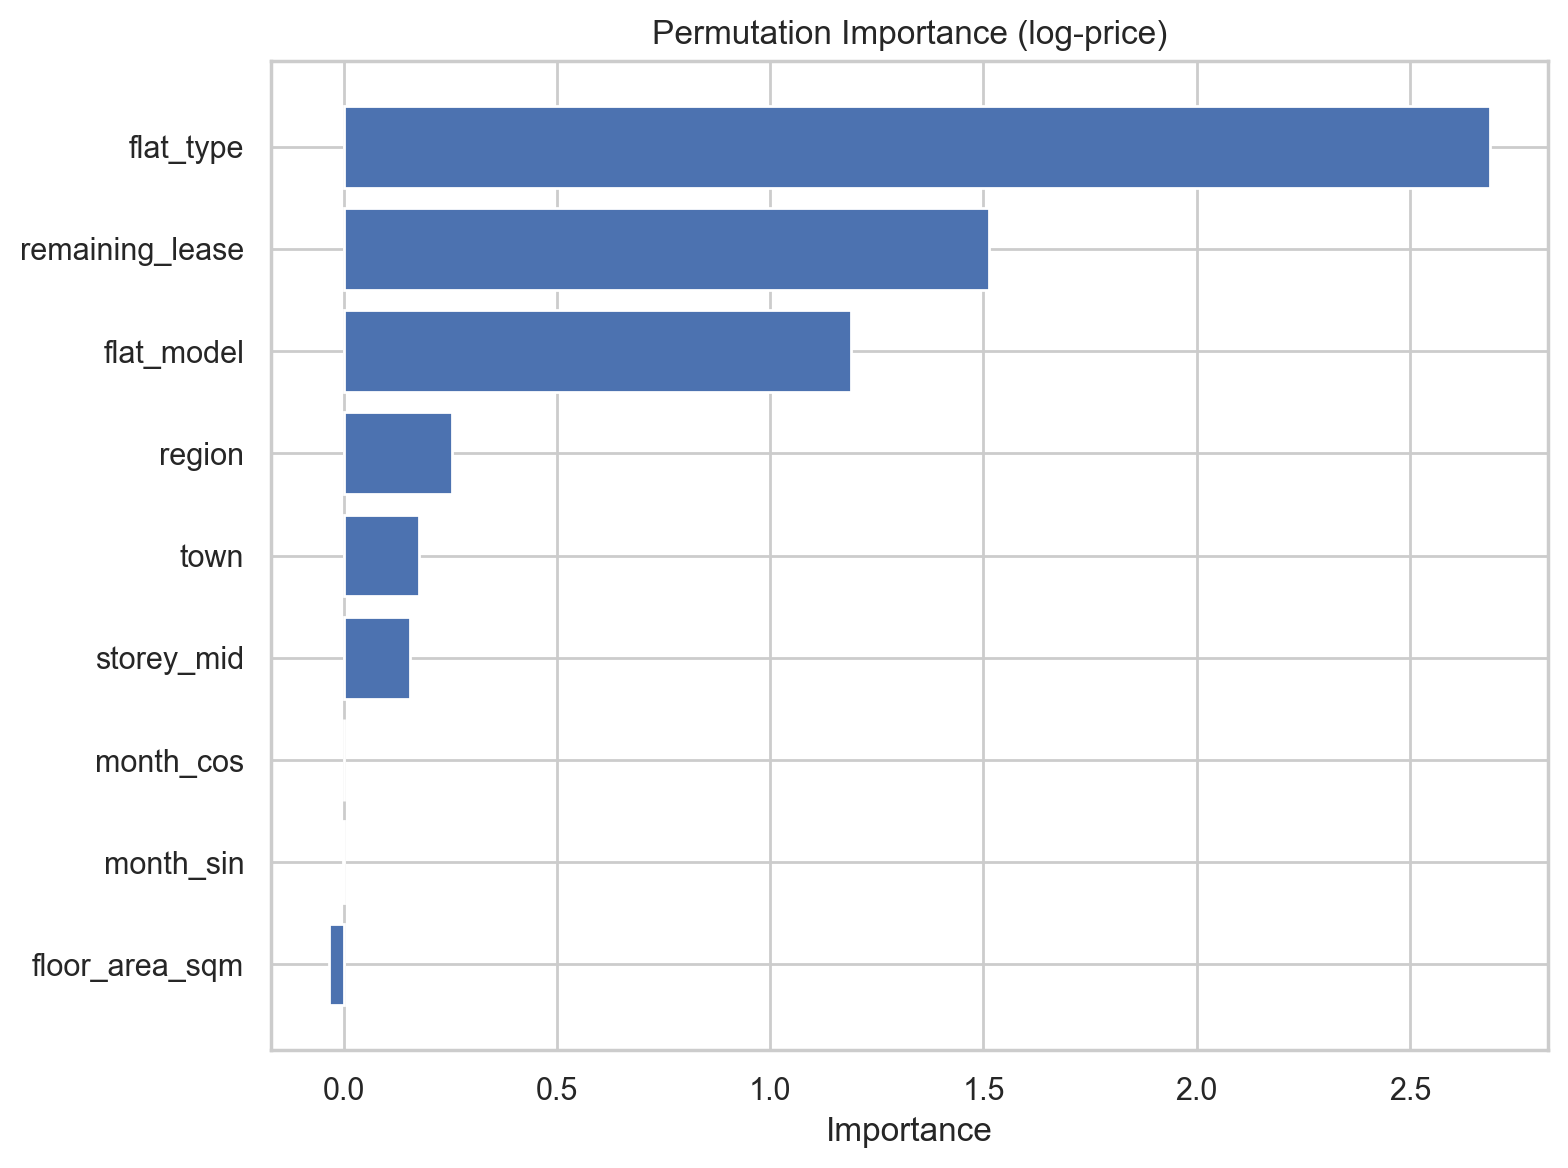

In [141]:
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor",   LinearRegression())
])

# Fit on log-transformed target
pipe.fit(X_train_full, np.log(train['resale_price']))

# Permutation importance on test set (log target)
r = permutation_importance(pipe, X_test, np.log(test['resale_price']), 
                           n_repeats=10, random_state=42)

sorted_idx = r.importances_mean.argsort()[-15:]  # top 15
plt.figure(figsize=(8,6),dpi=200)
plt.barh(np.array(model_features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importance (log-price)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


Permutation importance confirms key drivers of resale prices:  
- **flat type** → larger units cost more.  
- **Remaining lease** → shorter leases reduce value.  
- **flat model** → central/mature estates command premiums.  

Price is shaped mainly by **size, lease, location, and height**.  


## Model Prediction Task II


When building an in-house predictive model for housing prices, the following factors must be considered:

Data quality and coverage – Ensure transactions are cleaned, deduplicated, and enriched with relevant features (e.g., floor area, lease, town, policy periods). Missing or inconsistent values reduce model reliability.

Temporal structure – Housing markets shift over time due to policy and supply changes. Models must be trained with chronological splits to avoid data leakage and to reflect real-world forecasting.

Model choice and interpretability – Linear or ridge regression provides transparency for policy use, while tree-based methods capture non-linear effects. For government reporting, interpretability often matters more than raw accuracy.

Deployment constraints – Colleagues may only have CPU access. Lightweight, reproducible pipelines (scikit-learn, XGBoost) are preferable to GPU-heavy deep learning.

Maintenance and monitoring – Prices are affected by new policies and economic conditions. Models must be retrained regularly, and performance tracked to detect concept drift.

Finall, the model should balance predictive accuracy with interpretability, use clean and policy-aware features, and remain lightweight enough for broad in-house use.